**Summary Of Findings**:
It was found that  wildfire  frequency across the United State has been increasing in the past decade. Although fire and fire damage was generally localized to mostly the west coast in the past, fire frequency has been gradually increasing in states east of it in the continental US; in 2021, midwestern states have had fire counts similar to those found in West Coast states in 2014 and 2015. 
   It was also found that the number of recorded fires, did not necessarily correlate with the area affected for each states. While the degree of fire coverage has remained relatively consistent, the distribution of burned area across the United States has changed over the years. In the early 2000s, the majority of wildfire area was almost entirely localized to Alaska and the West coast; by 2021, the majority of  the US had seen more than minimal fire coverage. 

  Throughout the past decade, hot spots on on the continental US have remained relatively consistent; the west coast will probably continue to be considered hot spots, and some may become prominent in the Midwest. Regardless of hot spots, fire activity has generally increased across the United States.

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
!wget https://dlcdn.apache.org/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz

--2021-12-16 09:54:40--  https://dlcdn.apache.org/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 300965906 (287M) [application/x-gzip]
Saving to: ‘spark-3.2.0-bin-hadoop3.2.tgz’

spark-3.2.0-bin-had 100%[===================>] 287.02M   147MB/s    in 1.9s    

2021-12-16 09:54:42 (147 MB/s) - ‘spark-3.2.0-bin-hadoop3.2.tgz’ saved [300965906/300965906]



In [ ]:
!tar xvzf spark-3.2.0-bin-hadoop3.2.tgz

spark-3.2.0-bin-hadoop3.2/
spark-3.2.0-bin-hadoop3.2/NOTICE
spark-3.2.0-bin-hadoop3.2/kubernetes/
spark-3.2.0-bin-hadoop3.2/kubernetes/tests/
spark-3.2.0-bin-hadoop3.2/kubernetes/tests/python_executable_check.py
spark-3.2.0-bin-hadoop3.2/kubernetes/tests/autoscale.py
spark-3.2.0-bin-hadoop3.2/kubernetes/tests/worker_memory_check.py
spark-3.2.0-bin-hadoop3.2/kubernetes/tests/py_container_checks.py
spark-3.2.0-bin-hadoop3.2/kubernetes/tests/decommissioning.py
spark-3.2.0-bin-hadoop3.2/kubernetes/tests/pyfiles.py
spark-3.2.0-bin-hadoop3.2/kubernetes/tests/decommissioning_cleanup.py
spark-3.2.0-bin-hadoop3.2/kubernetes/dockerfiles/
spark-3.2.0-bin-hadoop3.2/kubernetes/dockerfiles/spark/
spark-3.2.0-bin-hadoop3.2/kubernetes/dockerfiles/spark/decom.sh
spark-3.2.0-bin-hadoop3.2/kubernetes/dockerfiles/spark/entrypoint.sh
spark-3.2.0-bin-hadoop3.2/kubernetes/dockerfiles/spark/bindings/
spark-3.2.0-bin-hadoop3.2/kubernetes/dockerfiles/spark/bindings/R/
spark-3.2.0-bin-hadoop3.2/kubernetes/docker

In [ ]:
!ls /content/spark-3.2.0-bin-hadoop3.2

bin   data	jars	    LICENSE   NOTICE  R		 RELEASE  yarn
conf  examples	kubernetes  licenses  python  README.md  sbin


In [ ]:
# Set the ‘environment’ path
import os
#os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop3.2"

In [ ]:
!pip install -q findspark

import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
import pandas as pd
import matplotlib.pyplot as plt


spark = SparkSession.builder\
    .master("local[*]")\
    .appName("final-project")\
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

In [ ]:
sc

<SparkContext master=local[*] appName=final-project>

In [ ]:
#The wildfire location database 
locatData = spark.read.option("header",True) \
.option("inferSchema", True) \
.csv("WFIGS_-_Wildland_Fire_Locations_Full_History.csv")

Fire Frequency By Year

In [ ]:
#Fires not considered "wildfire" are first filtered out
#locTime will be used to focus on the frequency of wildfires per state
#POOState - Location of wildfire at time of discovery
#FireDiscoveryDateTime - Date when the fire was discovered.

locatData = locatData.filter(locatData["IncidentTypeCategory"] == "WF")
locTime = locatData.select(substring(locatData["POOState"],0,6).alias("State Occurred"),
                           substring(locatData['FireDiscoveryDateTime'],0,4).alias("Year"))

In [ ]:
#Unusable rows are filtered out.
locTime = locTime.filter((locTime["year"].isNotNull())& (locTime["State Occurred"].isNotNull()))\

A significant difference between the wildfire frequency was found between 2013 and 2014; it is assumed the years before 2014 had incomplete data.

In [ ]:

locTime.groupBy("Year").count().orderBy("year").show()


+----+-----+
|Year|count|
+----+-----+
|2003|    1|
|2004|    1|
|2008|    1|
|2009|    1|
|2010|    2|
|2014|12634|
|2015|19633|
|2016|19798|
|2017|25114|
|2018|22627|
|2019|25451|
|2020|33348|
|2021|34488|
+----+-----+



Number of Fires across the  US per state

In [ ]:
#To gain insights into the US results, areas outside the US are filtered out.
locTime = locTime.filter(locTime["Year"] > 2013)
locTime = locTime.filter(locTime["State Occurred"].contains("US"))
locTime = locTime.withColumn("State Occurred",substring(locTime["State Occurred"],4,6))

In [ ]:
locTime.show()

In [ ]:
totalFiresPerState = locTime.groupBy("State Occurred").count()

In [ ]:
import plotly.express as px
import pandas as pd

fig = px.choropleth(totalFiresPerState.toPandas(), locations='State Occurred',locationmode = "USA-states",color = "count", 
                    scope='usa')
fig.update_layout(
    width=800,
    height=600)

fig.show()

Findings:
From the figure above, it can be seen that fires in the last decade have most occurred in the western portion of the United States, and have been mostly prevalent on the west coast as well as Montana and Arizona.

Number of Fires Per Year Per State

In [ ]:
firePerState = locTime.filter(locTime["year"].isNotNull())\
.groupBy("year",'State Occurred').count().orderBy("Year")

In [ ]:
firePerState.show()

+----+--------------+-----+
|year|State Occurred|count|
+----+--------------+-----+
|2014|            NM|  517|
|2014|            UT|  909|
|2014|            WI|   11|
|2014|            HI|    2|
|2014|            VA|   14|
|2014|            WA|  827|
|2014|            GA|   25|
|2014|            WY|  320|
|2014|            MI|   66|
|2014|            ID|  993|
|2014|            WV|    1|
|2014|            AR|   15|
|2014|            MO|    7|
|2014|            SC|   21|
|2014|            NE|   12|
|2014|            NV|  529|
|2014|            PA|   16|
|2014|            AZ|  948|
|2014|            CO|  619|
|2014|            AL|   32|
+----+--------------+-----+
only showing top 20 rows



In [ ]:
import plotly.express as px
import pandas as pd

fig = px.choropleth(firePerState.toPandas(), locations='State Occurred',locationmode = "USA-states",color = "count",range_color = [0,5000],
                    animation_frame="year", animation_group="State Occurred",scope='usa')
fig.update_layout(
    width=800,
    height=600)

fig.show()

**Findings** : From the above, figure, we see a general rise in wildfire occurences over the years. The west coast has consistently had the highest number of fires over the years. Originally the majority of fires had been originating in the west coast, but states east of it have steadily seen increasing occurences.In 2021, midwestern states such as North Dakota and Minnesota have had fire counts similar to those of western states in 2014 and 2015. It should be noted that data for 2021 is incomplete, so there may still be a gradual increase in fire count over the year.

Acres Burned In Historical Data Across the US

In [ ]:
#Primarily tracks historical fire Perimeters from 2000-2018
oldPerimData = spark.read.option("header",True) \
.option("inferSchema", True) \
.csv("Historic_GeoMAC_Perimeters_Combined_2000-2018.csv")


In [ ]:
#Meaningful data is cleaned and selected
oldPerimTime = oldPerimData.select((oldPerimData["state"]).alias("State Occurred"),
                             oldPerimData["gisacres"].alias("area(acres)"),
                             oldPerimData['fireyear'].alias("year"))
oldPerimTime = oldPerimTime.filter(oldPerimTime["year"].isNotNull())
oldPerimTime = oldPerimTime.filter(oldPerimTime["year"].cast("int").isNotNull())

In [ ]:
oldOverall = oldPerimTime.groupBy("year").agg(sum('area(acres)').alias("area (acres)")).orderBy("year")

In [ ]:
#The Data in this csv primarily tracks the area of each recorded fire; data is mostly available for 2020 and 2021.
perimData = spark.read.option("header",True) \
.option("inferSchema", True) \
.csv("WFIGS_-_Wildland_Fire_Perimeters_Full_History.csv")
perimData = perimData.filter(perimData["irwin_IncidentTypeCategory"] == "WF")

In [ ]:
#Data similar to columns found in oldPerimTime is cleaned and selected here.
recentTime = perimData.select(substring(perimData["irwin_POOState"],4,6).alias("State Occurred"),
                             perimData["poly_Acres_AutoCalc"].alias("area(acres)"),
                             substring(perimData['irwin_ContainmentDateTime'],0,4).alias("year"))
recentTime = recentTime.filter(recentTime["year"].isNotNull())

In [ ]:
recentOverall = recentTime.groupBy("year").agg(sum('area(acres)').alias("area (acres)")).orderBy("year")
recentOverall = recentOverall.filter((recentOverall["year"] == 2020) | (recentOverall["year"]  == 2021))

In [ ]:
recentOverall.show()

In [ ]:
combinedOverall = oldOverall.union(recentOverall)

Text(0.5, 1.0, 'Wildfire Damage from 2000-2021')

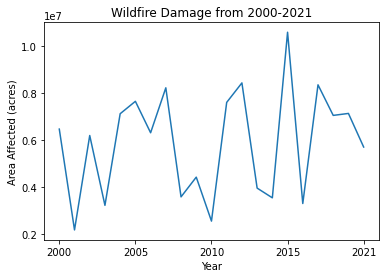

In [ ]:
yearMonth = combinedOverall.select("year").rdd.flatMap(lambda x: x).collect()
areaDamage = combinedOverall.select("area (acres)").rdd.flatMap(lambda x: x).collect()
ticks = [0,5,10,15,20]
plt.plot(yearMonth,areaDamage)
plt.xticks(ticks)
plt.xlabel("Year")
plt.ylabel("Area Affected (acres)")
plt.title("Wildfire Damage from 2000-2021")

**Findings**: In the above figure, it is found that the total area damaged by wildfires has been inconsistent throughout the past two decades; while fires are increasing in frequency, the area affected does not necessarily increase.

Total Area Burned Per State

In [ ]:
damagePerState = oldPerimTime.union(recentTime)

In [ ]:
damagePerStateOverall= damagePerState.groupBy("State Occurred").agg(sum('area(acres)').alias("total area burned (acres)"))

In [ ]:
import plotly.express as px
import pandas as pd
fig = px.choropleth(damagePerStateOverall.toPandas(), locations='State Occurred',locationmode = "USA-states",color = "total area burned (acres)", 
                    scope='usa')
fig.update_layout(
    width=800,
    height=600)

fig.show()

**Findings**: The above map shows that the most significant damage was found on the west coast; this is similar and supports the findings found in the occurences map. Some States that had a high number of fire occurences such as Texas have not seen proportional quantities of acres burned. In contrast to its low number of reported fires over the years, Alaska has the most significant fire damage found of any state.

Area Burned Per State Per Month

In [ ]:
damagePerStateYearly= damagePerState.groupBy("year","State Occurred").agg(sum('area(acres)').alias("total area burned (acres)")).orderBy("year")

In [ ]:
import plotly.express as px
import pandas as pd
fig = px.choropleth(damagePerStateYearly.toPandas(), locations='State Occurred',locationmode = "USA-states",color = "total area burned (acres)", 
                    range_color = [0,1000000],animation_frame="year", animation_group="State Occurred",scope='usa')
fig.update_layout(
    width=800,
    height=600)

fig.show()

**Findings**: Until 2005, damage was almost exclusively reported on the west coast.From 2010 onwards, most of the states had at least some reported damage. Although Alaska has the most damage overall, the area burned in the state has lessened recently. Although the total area burned has remained inconsistent throughout the years, it has been more evenly distributed throughout the United States. It should be noted that a lack of data from 2019 may affect the trends.

In [ ]:
stateData = spark.read.option("header",False) \
.option("inferSchema", True) \
.csv("stateAreas.csv")

In [ ]:
stateData.show()

+---+---------+
|_c0|      _c1|
+---+---------+
| AL|365210240|
| AK|167624960|
| AZ| 99822720|
| AR| 93155840|
| CA| 77673600|
| CO| 72730880|
| CT| 70275840|
| DE| 66387200|
| FL| 62147200|
| GA| 61441920|
| HI| 52960640|
| ID| 52587520|
| IL| 52366720|
| IN| 50954880|
| IA| 49201920|
| KS| 48574720|
| KY| 44156160|
| LA| 44094720|
| ME| 43954560|
| MD| 42612480|
+---+---------+
only showing top 20 rows



In [ ]:
#Dictionary to make the area of each state more accessible
from itertools import chain
from pyspark.sql.functions import create_map, lit
areaDict = {}
for row in stateData.rdd.toLocalIterator():
    areaDict[row._c0] = row._c1
areaMap = create_map([lit(x) for x in chain(*areaDict.items())])

In [ ]:
proportionPerState = damagePerStateYearly.withColumn("Burned/Area",damagePerStateYearly["total area burned (acres)"]/
                                                     areaMap[damagePerStateYearly["State Occurred"]])

In [ ]:
proportionPerState.show()

+----+--------------+-------------------------+--------------------+
|year|State Occurred|total area burned (acres)|         Burned/Area|
+----+--------------+-------------------------+--------------------+
|2000|            OR|       377289.95176840003|0.014887508198346508|
|2000|            NE|           70108.56892547|0.002103593642746...|
|2000|            NV|        544508.9496871302|0.016764438106130854|
|2000|            CA|          244813.82103893|0.003151827918867286|
|2000|            UT|            195037.036318|0.033977630644093544|
|2000|            ND|            2499.35592137|9.474147567056344E-5|
|2000|            SD|           87635.05255075|0.005684799668308501|
|2000|            AZ|           13052.02763741|1.307520736502671...|
|2000|            NM|        213331.1771532099|0.007105127772133914|
|2000|            AK|          750031.77334348|0.004474463548528095|
|2000|            CO|        65807.56416649999|9.048091287565885E-4|
|2000|            WA|           18

In [ ]:
import plotly.express as px
import pandas as pd

fig = px.choropleth(firePerState.toPandas(), locations='State Occurred',locationmode = "USA-states",color = "count",range_color = [0,5000],
                    animation_frame="year", animation_group="State Occurred",scope='usa')
fig.update_layout(
    width=800,
    height=600)

fig.show()

In [ ]:
import plotly.express as px
import pandas as pd
fig = px.choropleth(proportionPerState.toPandas(), locations='State Occurred',locationmode = "USA-states",color = "Burned/Area", 
                    range_color = [0,.1],animation_frame="year", animation_group="State Occurred",scope='usa')
fig.update_layout(
    width=800,
    height=600)

fig.show()